### + random transforms

In [1]:
RUN = 'C'

In [2]:
IMAGES_DIR = '/d2/caches/kaggle-planet/processed-images-64x64'
IMAGE_SHAPE = (64, 64, 4)

TRAIN_BATCH_SIZE = 53
TRAIN_EPOCHS = 100

VAL_SPLIT = 0.2

VAL_BATCH_SIZE = 16

TENSORBOARD_DIR = '/tensorboard/planet/' + RUN
MODEL_CHECKPOINT_DIR = '/d2/caches/kaggle-planet/models/' + RUN

In [4]:
%run 'Lib.ipynb'

In [5]:
import keras
from keras.layers import *
from keras.applications import *
from keras.models import *
from keras.callbacks import *

In [6]:
# load data
X_files = np.load('out/X_files.npy')
Y_tags_misc = np.load('out/Y_tags_misc.npy')
Y_tags_weather = np.load('out/Y_tags_weather.npy')

In [6]:
# split data into tran/val sets
from sklearn.model_selection import train_test_split

X_files_train, X_files_val, \
Y_tags_misc_train, Y_tags_misc_val, \
Y_tags_weather_train, Y_tags_weather_val = \
train_test_split(
    X_files,
    Y_tags_misc,
    Y_tags_weather,
    test_size=VAL_SPLIT,
    random_state=RND)

In [7]:
# calculate samples per epoch so that epoch can consist of integer number of batches
TRAIN_SAMPLES_PER_EPOCH = int(len(X_files_train) / TRAIN_BATCH_SIZE) * TRAIN_BATCH_SIZE
print ('Samples per epoch (train):', TRAIN_SAMPLES_PER_EPOCH, 'of', len(X_files_train))

Samples per epoch (train): 32383 of 32383


In [8]:
# calculate samples per epoch so that epoch can consist of integer number of batches
VAL_SAMPLES_PER_EPOCH = int(len(X_files_val) / VAL_BATCH_SIZE) * VAL_BATCH_SIZE
print ('Samples per epoch (val):', VAL_SAMPLES_PER_EPOCH, 'of', len(X_files_val))

Samples per epoch (val): 8096 of 8096


In [9]:
# define model
image_input = Input(shape=IMAGE_SHAPE, name='image_input')

x = Conv2D(32, (3, 3), padding='same')(image_input)
x = Conv2D(32, (3, 3), padding='same')(x)
x = MaxPool2D(pool_size=2)(x)

x = Conv2D(64, (3, 3), padding='same')(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = MaxPool2D(pool_size=2)(x)

x = Conv2D(128, (3, 3), padding='same')(x)
x = Conv2D(128, (3, 3), padding='same')(x)
x = MaxPool2D(pool_size=2)(x)

x = Conv2D(256, (3, 3), padding='same')(x)
x = Conv2D(256, (3, 3), padding='same')(x)
x = MaxPool2D(pool_size=2)(x)

x = Flatten()(x)
features = Dropout(rate=0.5)(x)

out_tags_misc = Dense(Y_tags_misc.shape[1], activation='sigmoid', name='tags_misc')(features)
out_tags_weather = Dense(Y_tags_weather.shape[1], activation='softmax', name='tags_weather')(features)

model = Model(inputs=[image_input], outputs=[out_tags_misc, out_tags_weather])

In [10]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
image_input (InputLayer)         (None, 64, 64, 4)     0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 64, 64, 32)    1184        image_input[0][0]                
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 64, 64, 32)    9248        conv2d_1[0][0]                   
____________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 32, 32, 32)    0           conv2d_2[0][0]                   
___________________________________________________________________________________________

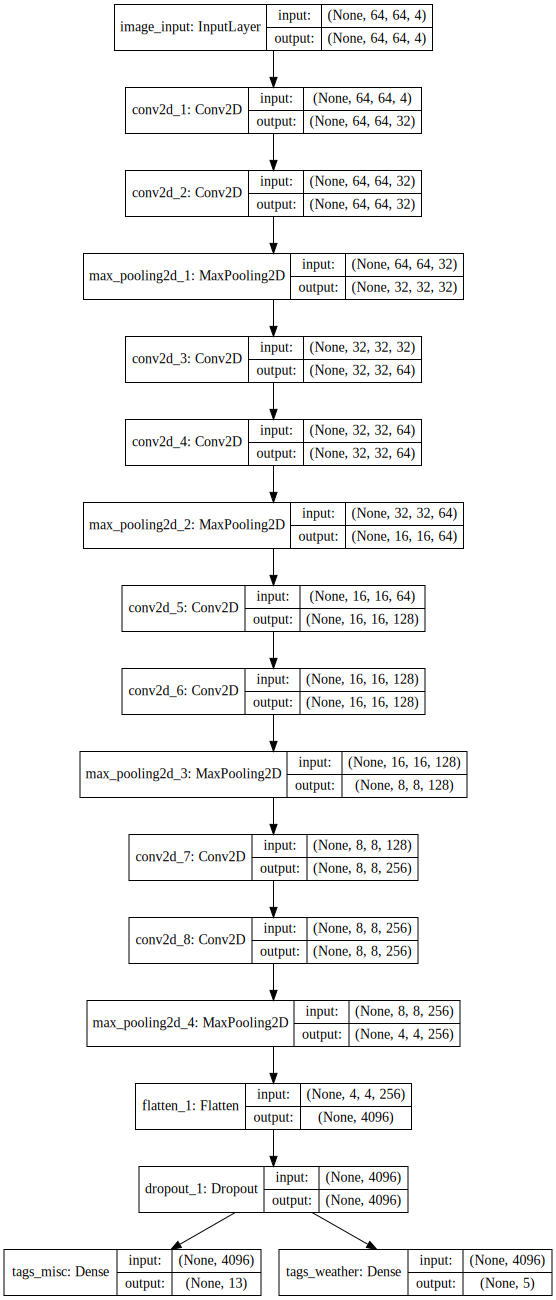

In [11]:
model_as_svg(model)

In [12]:
model.compile(
    optimizer='rmsprop',
    loss={
        'tags_misc': 'binary_crossentropy',
        'tags_weather': 'binary_crossentropy'
    },
    loss_weights={'tags_misc': 1.,
                  'tags_weather': 0.5})

In [ ]:
# data generation


def train_generator():
    batch_index = -1

    while True:
        batch_index += 1

        yield generate_batch(
            n_samples=TRAIN_BATCH_SIZE,
            batch_index=batch_index,
            X_files=X_files_train,
            Y_tags_misc=Y_tags_misc_train,
            Y_tags_weather=Y_tags_weather_train,
            images_dir=IMAGES_DIR,
            image_shape=IMAGE_SHAPE)


def val_generator():
    batch_index = -1

    while True:

        yield generate_batch(
            n_samples=VAL_BATCH_SIZE,
            batch_index=batch_index,
            X_files=X_files_val,
            Y_tags_misc=Y_tags_misc_val,
            Y_tags_weather=Y_tags_weather_val,
            images_dir=IMAGES_DIR,
            image_shape=IMAGE_SHAPE)

In [ ]:
model.fit_generator(
    train_generator(),
    steps_per_epoch=TRAIN_SAMPLES_PER_EPOCH,
    epochs=TRAIN_EPOCHS,
    verbose=1,
    callbacks=[
        TensorBoard(log_dir=TENSORBOARD_DIR, histogram_freq=0),
        ModelCheckpoint(
                MODEL_CHECKPOINT_DIR + \
                '/e{epoch:02d}-l={loss:.5f}-vl={val_loss:.5f}.h5',
                monitor='val_loss', verbose=0, save_best_only=False,
                save_weights_only=False, mode='auto'
            ),
    ],
    validation_data=val_generator(),
    validation_steps=VAL_SAMPLES_PER_EPOCH,
    class_weight=None,
    max_q_size=10,
    workers=1,
    pickle_safe=False,
    initial_epoch=0)

Epoch 1/100
32380/32383 [============================>.] - ETA: 0s - loss: 0.2480 - tags_misc_loss: 0.1647 - tags_weather_loss: 0.1666

In [20]:
from keras.preprocessing.image import random_rotation, random_zoom, random_shear, random_shift

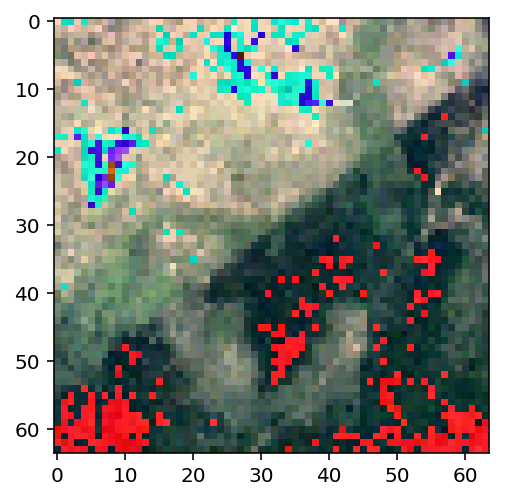

In [43]:
img = np.fromfile('/d2/caches/kaggle-planet/processed-images-64x64/file_999', dtype=np.float32).reshape(IMAGE_SHAPE)
plt.imshow(img[:,:,:3])

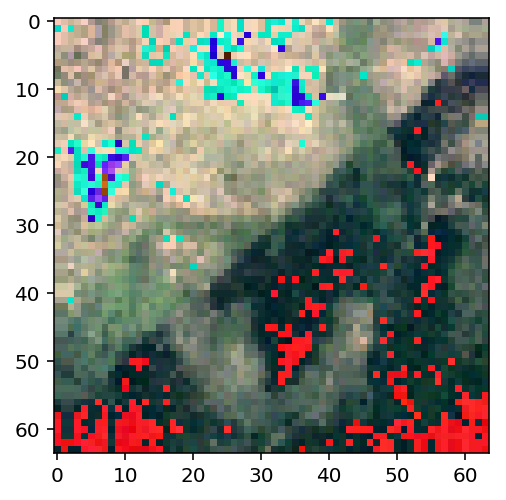

In [44]:
img_ = random_rotation(img, 30, row_axis=0, col_axis=1, channel_axis=2, fill_mode='reflect')
plt.imshow(img_[:,:,:3])

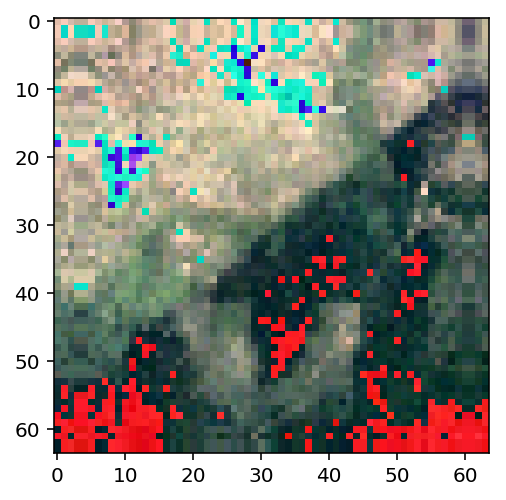

In [36]:
img_ = random_zoom(img, (0.75, 1.25), row_axis=0, col_axis=1, channel_axis=2, fill_mode='reflect')
plt.imshow(img_[:,:,:3])

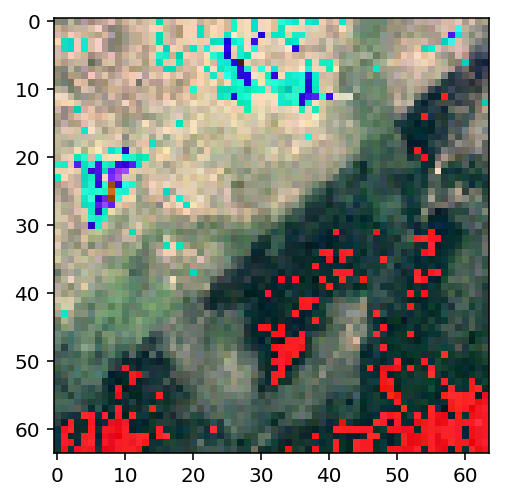

In [61]:
img_ = random_shear(img, 0.25, row_axis=0, col_axis=1, channel_axis=2, fill_mode='reflect')
plt.imshow(img_[:,:,:3])

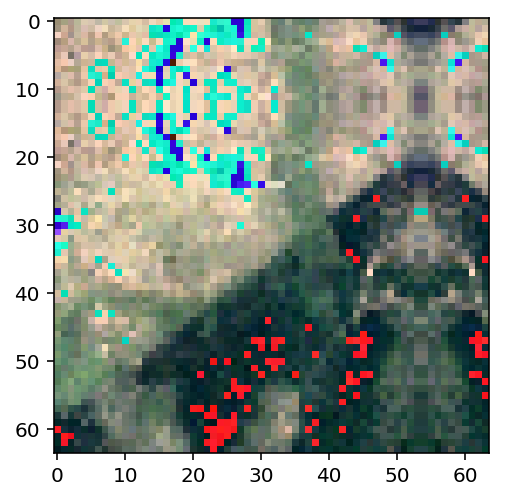

In [65]:
img_ = random_shift(img, 0.25, 0.25, row_axis=0, col_axis=1, channel_axis=2, fill_mode='reflect')
plt.imshow(img_[:,:,:3])

In [139]:
_ = random_transform(img)

Random shift applied (0.25, 0.25)


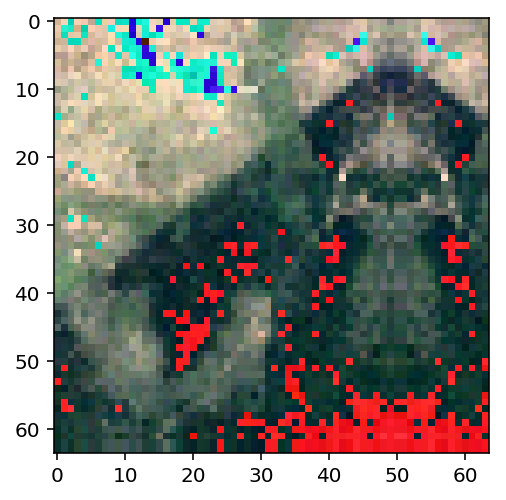

In [140]:
plt.imshow(_[:,:,:3])